# Hello World Mobilenet Imagenet

## Imports

In [1]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
base_dir = '/content/drive/MyDrive/dados/HAM10000subset'
base_dir = 'HAM10000/HAM10000subset/'

## Train/test split

In [3]:
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
dataset_split_percentage = 0.5 # 0.8 # percentage of images for training
IMG_SHAPE = 224

for cl in classes:
    img_path = os.path.join(base_dir, cl)
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Images".format(cl, len(images)))
    num_train = int(round(len(images) * dataset_split_percentage))
    train, val = images[:num_train], images[num_train:]

    for t in train:
        if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
        bn=os.path.basename(t)
        if not os.path.exists(os.path.join(base_dir, 'train', cl, bn)):
            shutil.move(t, os.path.join(base_dir, 'train', cl))

    for v in val:
        if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))
        bn = os.path.basename(v)
        if not os.path.exists(os.path.join(base_dir, 'val', cl, bn)):
            shutil.move(v, os.path.join(base_dir, 'val', cl))

print("training images:", round(len(images)*dataset_split_percentage))
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')


akiec: 100 Images
bcc: 100 Images
bkl: 100 Images
df: 100 Images
mel: 100 Images
nv: 100 Images
vasc: 100 Images
training images: 50


In [5]:
batch_size = 16

image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5)
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='sparse')

image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=batch_size,
    directory=val_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='sparse')


Found 350 images belonging to 7 classes.
Found 350 images belonging to 7 classes.


## Load Mobilenet model

In [6]:
model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet')
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [7]:
model.trainable = False
base_output = model.layers[-2].output # layer number obtained from model summary above
new_output = tf.keras.layers.Dense(7, activation="softmax")(base_output)
modelMobilenetSkin = tf.keras.models.Model(inputs=model.inputs, outputs=new_output)
modelMobilenetSkin.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [8]:
modelMobilenetSkin.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

## Train

In [9]:
epochs = 10
history = modelMobilenetSkin.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))) )


Epoch 1/10
22/22 [==============================] - 19s 800ms/step - loss: 2.0530 - accuracy: 0.2233 - val_loss: 1.7746 - val_accuracy: 0.2971
Epoch 2/10
22/22 [==============================] - 17s 761ms/step - loss: 1.7038 - accuracy: 0.3114 - val_loss: 1.6740 - val_accuracy: 0.3629
Epoch 3/10
22/22 [==============================] - 17s 804ms/step - loss: 1.4966 - accuracy: 0.4335 - val_loss: 1.6005 - val_accuracy: 0.3914
Epoch 4/10
22/22 [==============================] - 20s 942ms/step - loss: 1.4692 - accuracy: 0.4530 - val_loss: 1.6003 - val_accuracy: 0.3943
Epoch 5/10
22/22 [==============================] - 19s 889ms/step - loss: 1.3951 - accuracy: 0.4315 - val_loss: 1.5328 - val_accuracy: 0.4229
Epoch 6/10
22/22 [==============================] - 19s 882ms/step - loss: 1.2778 - accuracy: 0.5263 - val_loss: 1.5960 - val_accuracy: 0.4171
Epoch 7/10
22/22 [==============================] - 19s 875ms/step - loss: 1.2659 - accuracy: 0.5266 - val_loss: 1.5111 - val_accuracy: 0.4314

Text(0.5, 1.0, 'Training and Validation Loss')

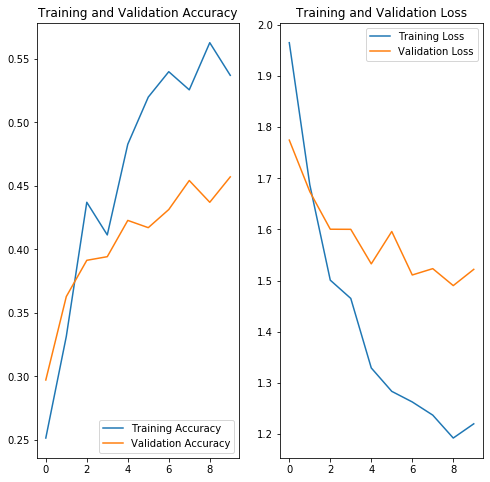

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

## Use the model to predict classes

In [29]:
Y_predict = modelMobilenetSkin.predict(val_data_gen)

In [30]:
Y_predict[0]

array([0.03687787, 0.01538077, 0.16114515, 0.19663265, 0.04579278,
       0.5430943 , 0.00107651], dtype=float32)

In [31]:

Y_predicted_label = np.argmax(Y_predict, axis=-1)
Y_predicted_label

array([5, 5, 3, 2, 6, 5, 2, 1, 5, 6, 1, 3, 6, 6, 2, 4, 1, 2, 6, 4, 4, 2,
       6, 6, 1, 4, 0, 1, 2, 2, 2, 0, 0, 2, 1, 1, 2, 3, 5, 2, 5, 5, 1, 6,
       6, 5, 6, 3, 5, 2, 5, 4, 2, 6, 3, 2, 1, 3, 2, 6, 3, 2, 2, 1, 1, 5,
       2, 2, 3, 3, 0, 4, 4, 3, 6, 0, 2, 2, 4, 1, 5, 6, 2, 6, 2, 1, 1, 1,
       6, 3, 1, 2, 5, 5, 1, 3, 4, 4, 1, 2, 6, 4, 2, 4, 2, 3, 2, 1, 5, 2,
       4, 5, 4, 1, 2, 2, 5, 1, 5, 1, 6, 6, 3, 2, 2, 2, 2, 1, 5, 5, 4, 1,
       6, 6, 1, 2, 5, 5, 2, 3, 0, 2, 2, 2, 3, 0, 4, 6, 2, 2, 0, 2, 2, 2,
       2, 5, 2, 5, 2, 6, 6, 2, 0, 6, 1, 2, 5, 6, 6, 2, 6, 3, 2, 0, 1, 5,
       2, 1, 2, 4, 2, 3, 2, 5, 5, 4, 2, 6, 0, 5, 6, 5, 6, 5, 0, 2, 2, 2,
       2, 5, 1, 6, 2, 5, 4, 2, 2, 5, 2, 6, 4, 5, 2, 3, 0, 2, 2, 6, 4, 2,
       6, 4, 2, 2, 6, 5, 2, 2, 6, 1, 2, 0, 1, 6, 4, 1, 4, 5, 0, 1, 2, 4,
       4, 2, 2, 3, 1, 6, 6, 2, 6, 4, 6, 5, 5, 6, 5, 2, 6, 2, 2, 4, 6, 6,
       1, 5, 2, 4, 2, 3, 5, 4, 5, 5, 0, 6, 0, 5, 1, 2, 1, 1, 0, 2, 5, 1,
       5, 2, 2, 4, 4, 1, 5, 6, 2, 1, 1, 2, 3, 2, 1,

In [20]:
Y_val = np.zeros(350,)
Y_val[50:100]=1
Y_val[100:150]=2
Y_val[150:200]=3
Y_val[200:250]=4
Y_val[250:300]=5
Y_val[300:350]=6
Y_val.shape

(350,)

In [ ]:
T_pred

In [21]:
from sklearn import metrics
cm = metrics.confusion_matrix(Y_val, Y_predicted_label, labels=[0, 1, 2, 3, 4, 5, 6])
print("Confusion Matrix:")
print(cm)

prfs = metrics.precision_recall_fscore_support(Y_val, Y_predicted_label)
print("Precision Recall F-score Support:")
print(prfs)

accuracy = metrics.accuracy_score(Y_val, Y_predicted_label)
print("Accuracy:")
print(accuracy)

cr = metrics.classification_report(Y_val, Y_predicted_label)
print("Classification Report:")
print(cr)

Confusion Matrix:
[[0 0 0 ... 3 4 1]
 [0 0 0 ... 2 1 0]
 [0 0 0 ... 1 4 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Precision Recall F-score Support:
(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]), array([50., 50., 50., 50., 50., 50., 50.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0

d:\jhasb\documents\aulas\ipca\disciplinas\projectos\helloworlds\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\jhasb\documents\aulas\ipca\disciplinas\projectos\helloworlds\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
